In [1]:
import numpy as np
import pandas as pd

import csv
import datetime

import os
import re
import time

import math
import string

import matplotlib.pyplot as plt
from collections import Counter, defaultdict

##sklearn metrices and models
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split


##torch and transformers
import torch
from torch.utils.data import Dataset, random_split, DataLoader, \
                             RandomSampler, SequentialSampler
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    MT5ForConditionalGeneration,
    PreTrainedTokenizer,
    T5TokenizerFast as T5Tokenizer,
    MT5TokenizerFast as MT5Tokenizer,
    BertTokenizer
)
from transformers import AutoTokenizer, AutoConfig, AutoModelForPreTraining, \
                         AdamW, get_linear_schedule_with_warmup, \
                         TrainingArguments, BeamScorer, Trainer                         
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from transformers import pipeline
from transformers import BertModel, BertConfig

##gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,Word2Vec

##nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import pos_tag
from nltk.corpus import wordnet

In [2]:
##Spacy
import spacy
from spacy import displacy
import en_core_web_sm

C:\softwares\conda4.8.2-python3.7\lib\site-packages\spacy\util.py:730: UserWarning: [W095] Model 'en_core_web_sm' (2.3.0) was trained with spaCy v2.3 and may not be 100% compatible with the current version (3.1.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [3]:
df = pd.read_csv('data/sentiments_rule.csv')
df = df.drop(['Unnamed: 0'],axis=1)
df['data'] = df[' data ']
df = df.drop([' data '],axis=1)
df = df.dropna()


In [4]:
rating_df = df[['data','rating']]
neudf = rating_df[rating_df['rating']==2].sample(frac=1)
posdf = rating_df[rating_df['rating']==3].sample(frac=1)
negdf = rating_df[rating_df['rating']==1].sample(frac=1)
posdf = posdf[:5000] 
neudf = neudf[:10000]
main_df = pd.concat([neudf,posdf,negdf]).sample(frac=1)
main_df.rating = main_df.rating - 1

In [10]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [11]:
token_lens = []
for txt in main_df.data:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [12]:
import seaborn as sns

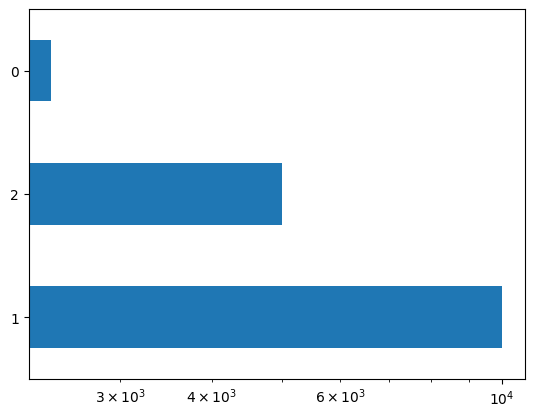

In [13]:
ax = main_df.rating.value_counts().plot(kind='barh')
ax.set_xscale('log')
plt.show()

C:\softwares\conda4.8.2-python3.7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


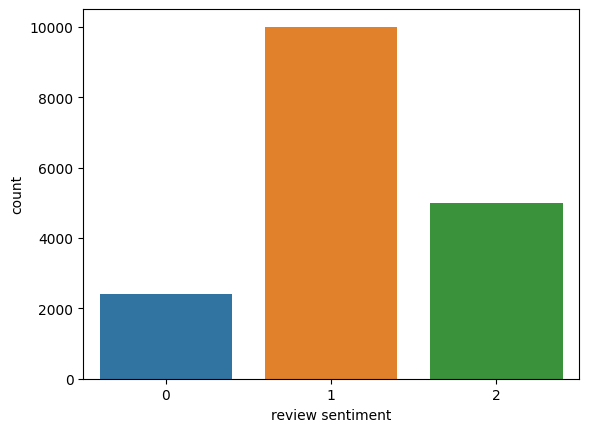

In [14]:
ax = sns.countplot(main_df.rating)
plt.xlabel('review sentiment')
plt.show()

C:\softwares\conda4.8.2-python3.7\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


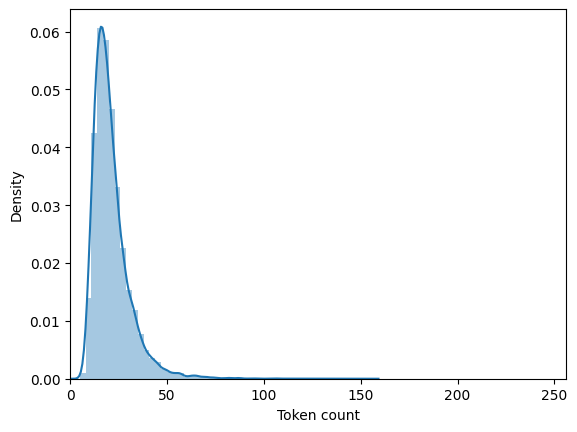

In [15]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
plt.show()

In [16]:
MAX_LEN = 160

In [17]:
class OKRCommentDataset(Dataset):

    def __init__(self, okrs, targets, tokenizer, max_len):
        self.okrs = okrs
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.okrs)

    def __getitem__(self, item):
        okr = str(self.okrs[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          okr,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'okr_text': okr,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [18]:
df_train, df_test = train_test_split(main_df, test_size=0.1, random_state=1234)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=1234)

In [19]:
len(df_train)

15669

C:\softwares\conda4.8.2-python3.7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


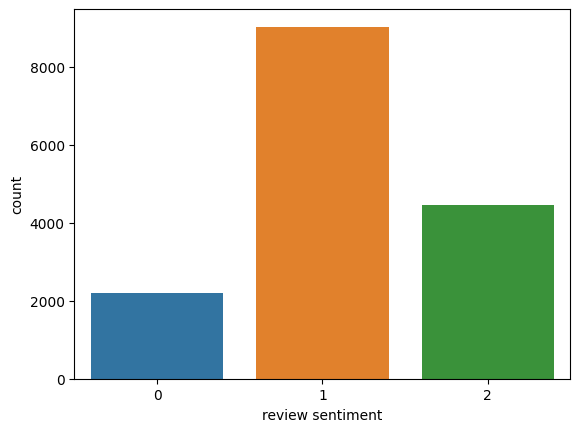

In [20]:
ax = sns.countplot(df_train.rating)
plt.xlabel('review sentiment')
plt.show()

In [21]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    
    ds= OKRCommentDataset(
        okrs=df.data.to_numpy(),
        targets=df.rating.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
  )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
  )

In [22]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [23]:
data = next(iter(train_data_loader))
data.keys()

C:\softwares\conda4.8.2-python3.7\lib\site-packages\transformers\tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['okr_text', 'input_ids', 'attention_mask', 'targets'])

In [24]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([4, 160])
torch.Size([4, 160])
torch.Size([4])


In [25]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
sample_txt = rating_df[' data '].tolist()[15000]

In [27]:
sample_txt

'Achieve licensed nursing hour per patient day budget 4.9 report MTD weekly result from NHPPD spreadsheet'

In [28]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']
encoding.keys()

32


dict_keys(['input_ids', 'attention_mask'])

In [29]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [30]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'A',
 '##chi',
 '##eve',
 'licensed',
 'nursing',
 'hour',
 'per',
 'patient',
 'day',
 'budget',
 '4',
 '.',
 '9',
 'report',
 'M',
 '##T',
 '##D',
 'weekly',
 'result',
 'from',
 'NH',
 '##PP',
 '##D',
 'spreads',
 '##hee',
 '##t',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [31]:
bert_model.config.hidden_size

768

In [32]:
import torch.nn as nn

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
class SentimentClassifier(nn.Module):

     def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
     def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [35]:
class_names = main_df.rating.unique().tolist()

In [36]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 160])
torch.Size([4, 160])


In [38]:
import torch.nn.functional as F

In [39]:
EPOCHS = 15

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [40]:
def train_epoch(
                  model, 
                  data_loader, 
                  loss_fn, 
                  optimizer, 
                  device, 
                  scheduler, 
                  n_examples
                ):
    
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
           
            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )           
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [41]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
        model = model.eval()
        losses = []
        correct_predictions = 0

        with torch.no_grad():
            for d in data_loader:
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)

                outputs = model(
                  input_ids=input_ids,
                  attention_mask=attention_mask
                )
                _, preds = torch.max(outputs, dim=1)
 
                loss = loss_fn(outputs, targets)

                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())

        return correct_predictions.double() / n_examples, np.mean(losses)

In [42]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
            model,
            train_data_loader,    
            loss_fn, 
            optimizer, 
            device, 
            scheduler, 
            len(df_train)
            )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
            model,
            val_data_loader,
            loss_fn, 
            device, 
            len(df_val)
      )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/2
----------
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

KeyboardInterrupt: 

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
                            model,
                            test_data_loader,
                            loss_fn,
                            device,
                            len(df_test)
                        )
test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
    
        model = model.eval()  
        okr_texts = []
        predictions = []
        prediction_probs = []
        real_values = []

        with torch.no_grad():
            for d in data_loader:
                texts = d["review_text"]
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                  )
                _, preds = torch.max(outputs, dim=1)

                probs = F.softmax(outputs, dim=1)

                okr_texts.extend(texts)
                predictions.extend(preds)
                prediction_probs.extend(probs)
                real_values.extend(targets)
                
        predictions = torch.stack(predictions).cpu()
        prediction_probs = torch.stack(prediction_probs).cpu()
        real_values = torch.stack(real_values).cpu()
        return review_texts, predictions, prediction_probs, real_values


In [ ]:
y_okr_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [43]:
def show_confusion_matrix(confusion_matrix):
      hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
      hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
      hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
      plt.ylabel('True sentiment')
      plt.xlabel('Predicted sentiment');

In [45]:
from sklearn.metrics import  confusion_matrix

In [44]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

NameError: name 'confusion_matrix' is not defined